Choose $$X_0 = \arg \min_{X \subset X_\text{train}, |X| \leq k} \mathbb{E}_{x_0 \sim D} [x_0^\top (\sum_{x \in X}xx^\top)^{-1}x_0].$$

Then $$\mathbb{E}_{(x_0,y_0) \sim D} [(y_0 - \hat \theta_{X_0} x_0)^2] = 1+ \mathbb{E}_{(x_0,y_0) \sim D} [x_0^\top (\sum_{x \in X_0}xx^\top)^{-1}x_0].$$

Continuous relaxation 

$$ w = \arg \min_{w \in \mathbb{R}^n_+} \mathbb{E}_{x_0 \sim D} [x_0^\top (\sum_{x_i \in X_{train}}w_i x_ix_i^\top)^{-1}x_0] + \lambda \|w\|_1 + \lambda_1 \|w\|_p.$$

In [213]:
from collections import defaultdict
from itertools import product
from time import perf_counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_diabetes

from tqdm.notebook import tqdm
import cvxpy as cp

## setup datasets

In [13]:
random_state = 0
num_features = 5

In [54]:
def scatter(x, y, best_fit=True):
    plt.scatter(x, y, marker='.')
    if best_fit:
        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x+b, 'k')
    plt.show()

**diabetes**

In [128]:
data = load_diabetes()
diabetes_x = data["data"][:, :num_features]
diabetes_y = data["target"]

MMS = MinMaxScaler()
diabetes_scaled_x = MMS.fit_transform(diabetes_x)

diabetes_train_x, diabetes_test_x, diabetes_train_y, diabetes_test_y = train_test_split(diabetes_scaled_x, diabetes_y, test_size=0.338, random_state=random_state)
diabetes_buyer_x, diabetes_seller_x, diabetes_buyer_y, diabetes_seller_y = train_test_split(diabetes_train_x, diabetes_train_y, train_size=0.344, random_state=random_state)
diabetes_seller_x.shape, diabetes_buyer_x.shape, diabetes_test_x.shape

((192, 5), (100, 5), (150, 5))

**housing**

In [129]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
housing_df = pd.read_csv('../data/housing.csv', header=None, delimiter=r"\s+", names=column_names)

housing_x = housing_df.iloc[:, :num_features].values
housing_y = housing_df.MEDV.values

MMS = MinMaxScaler()
housing_scaled_x = MMS.fit_transform(housing_x)

housing_train_x, housing_test_x, housing_train_y, housing_test_y = train_test_split(housing_scaled_x, housing_y, test_size=0.295, random_state=random_state)
housing_buyer_x, housing_seller_x, housing_buyer_y, housing_seller_y = train_test_split(housing_train_x, housing_train_y, train_size=0.281, random_state=random_state)
housing_seller_x.shape, housing_buyer_x.shape, housing_test_x.shape

((256, 5), (100, 5), (150, 5))

**random**

In [131]:
random_seller_x = MMS.fit_transform(np.random.randn(200, num_features))
random_buyer_x = MMS.fit_transform(np.random.randn(100, num_features))
random_test_x = MMS.fit_transform(np.random.randn(150, num_features))
random_seller_y = np.random.randn(200)
random_buyer_y = np.random.randn(100)
random_test_y = np.random.randn(150)

In [186]:
# TODO shuffle order of data (shouldn't make a difference but double check)

seller_data_x = np.concatenate([
    diabetes_seller_x,
    housing_seller_x,
    random_seller_x,
])

seller_data_y = np.concatenate([
    diabetes_seller_y,
    housing_seller_y,
    random_seller_y,
])

## experimental design

In [378]:
import cvxpy as cp

def optimize_seller_weights(seller_data, buyer_data, lam1=1, lam2=1,):
    
    num_seller_data = seller_data.shape[0]
    seller_weights = cp.Variable((num_seller_data, 1))
    
    def objective(seller_weights, seller_data, buyer_data, lam1=lam1, lam2=lam2):
        cost = cp.matrix_frac(
                buyer_data.T,
                cp.sum([
                    seller_weights[i] * seller_data[i][None].T @ seller_data[i][None] 
                     for i in range(seller_data.shape[0])
                ])
            ) / (buyer_data.shape[0])
        reg1 = cp.norm1(seller_weights)
        reg2 = cp.pnorm(seller_weights)
        loss = cost + lam1 * reg1 + lam2 * reg2
        return loss
    
    constraints = [seller_weights >= 0]
    prob = cp.Problem(cp.Minimize(objective(seller_weights, seller_data, buyer_data)), constraints)
    start = perf_counter()
    prob.solve()
    end = perf_counter()
    runtime = end - start
    print(prob.status, f"{runtime//60:.0f}:{runtime%60:.2f}\t{prob.value=:.2f}")
    return seller_weights.value.flatten()




In [262]:
diabetes_weights = {}
housing_weights = {}
random_weights = {}

for k in tqdm(np.arange(0, 101, 10)):
    if k == 0: k = 1
    diabetes_weights[k] = optimize_seller_weights(seller_data_x, diabetes_buyer_x[:k])
    housing_weights[k] = optimize_seller_weights(seller_data_x, housing_buyer_x[:k])
    random_weights[k] = optimize_seller_weights(seller_data_x, random_buyer_x[:k])

  0%|          | 0/11 [00:00<?, ?it/s]

optimal 0:1.82	prob.value=2.15
optimal 0:1.24	prob.value=2.52
optimal 0:1.27	prob.value=2.47
optimal 0:1.86	prob.value=2.83
optimal 0:1.31	prob.value=3.49
optimal 0:1.28	prob.value=2.99
optimal 0:1.67	prob.value=2.79
optimal 0:1.88	prob.value=3.19
optimal 0:1.43	prob.value=3.29
optimal 0:2.17	prob.value=2.62
optimal 0:1.46	prob.value=3.43
optimal 0:1.82	prob.value=3.33
optimal 0:2.10	prob.value=2.57
optimal 0:1.89	prob.value=3.35
optimal 0:1.69	prob.value=3.33
optimal 0:2.86	prob.value=2.46
optimal 0:1.76	prob.value=3.31
optimal 0:2.11	prob.value=3.28
optimal 0:3.16	prob.value=2.51
optimal 0:2.26	prob.value=3.30
optimal 0:2.58	prob.value=3.19
optimal 0:4.28	prob.value=2.46
optimal 0:3.08	prob.value=3.24
optimal 0:2.96	prob.value=3.22
optimal 0:6.52	prob.value=2.54
optimal 0:3.91	prob.value=3.25
optimal 0:3.59	prob.value=3.19
optimal 0:7.81	prob.value=2.60
optimal 0:4.43	prob.value=3.25
optimal 0:3.70	prob.value=3.21
optimal 0:10.87	prob.value=2.54
optimal 0:5.89	prob.value=3.26
optimal

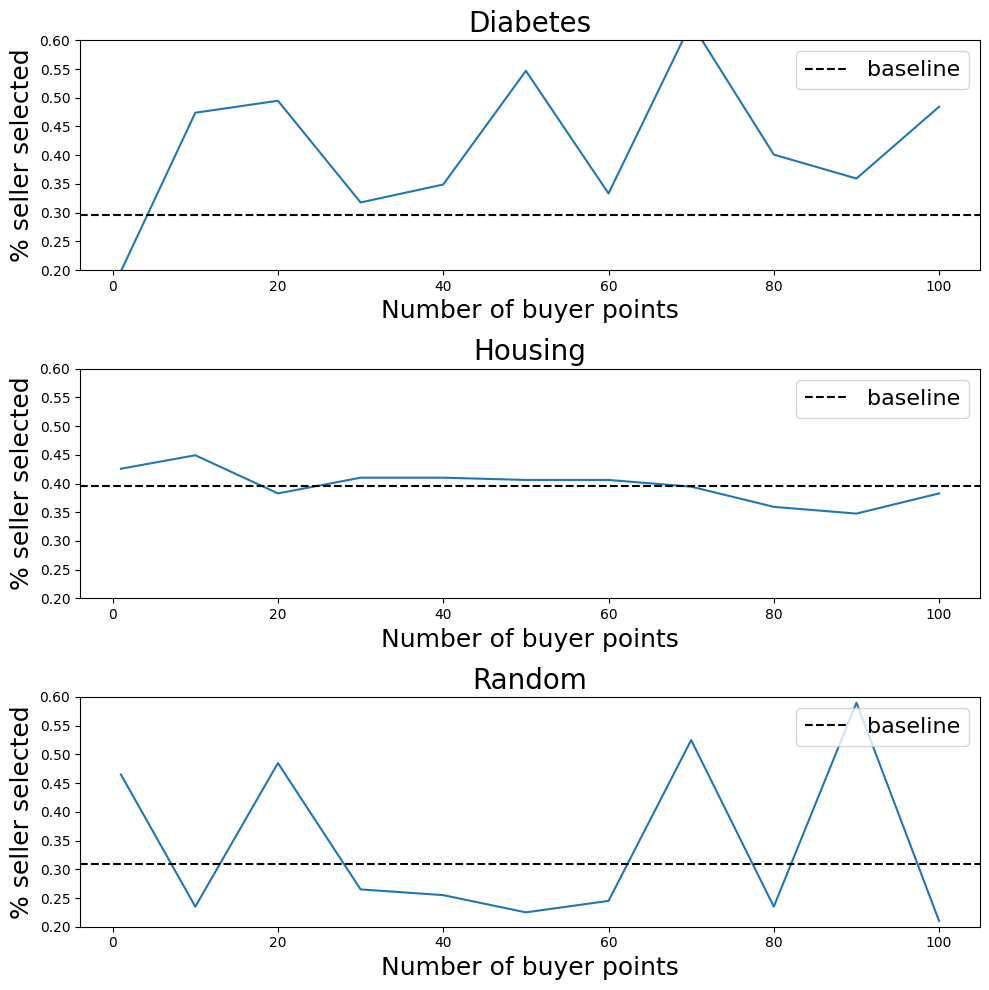

In [277]:
m = seller_data_x.shape[0]

m_diabetes = diabetes_seller_x.shape[0]
num_diabetes_selected = []
for k in diabetes_weights.keys():
    num_diabetes_selected.append((diabetes_weights[k].argsort()[::-1][:m_diabetes] < m_diabetes).sum() / m_diabetes)
    
m_housing = housing_seller_x.shape[0]
num_housing_selected = []
for k in housing_weights.keys():
    num_housing_selected.append((housing_weights[k].argsort()[::-1][:m_housing] < m_housing).sum() / m_housing)
    
m_random = random_seller_x.shape[0]
num_random_selected = []
for k in random_weights.keys():
    num_random_selected.append((random_weights[k].argsort()[::-1][:m_random] < m_random).sum() / m_random)
    
fig, ax = plt.subplots(nrows=3, figsize=(10, 10))
ax[0].plot(diabetes_weights.keys(), num_diabetes_selected)
ax[0].axhline(m_diabetes / seller_data_x.shape[0], c='k', ls='--', label='baseline')
ax[0].set_title('Diabetes', fontsize=20)
ax[0].set_xlabel('Number of buyer points', fontsize=18)
ax[0].set_ylabel('% seller selected', fontsize=18)
ax[0].legend(fontsize=16, loc='upper right')
ax[0].set_ylim(0.2, 0.6)

ax[1].plot(housing_weights.keys(), num_housing_selected)
ax[1].axhline(m_housing / seller_data_x.shape[0], c='k', ls='--', label='baseline')
ax[1].set_title('Housing', fontsize=20)
ax[1].set_xlabel('Number of buyer points', fontsize=18)
ax[1].set_ylabel('% seller selected', fontsize=18)
ax[1].legend(fontsize=16, loc='upper right')
ax[1].set_ylim(0.2, 0.6)

ax[2].plot(random_weights.keys(), num_random_selected)
ax[2].axhline(m_random / seller_data_x.shape[0], c='k', ls='--', label='baseline')
ax[2].set_title('Random', fontsize=20)
ax[2].set_xlabel('Number of buyer points', fontsize=18)
ax[2].set_ylabel('% seller selected', fontsize=18)
ax[2].legend(fontsize=16, loc='upper right')
ax[2].set_ylim(0.2, 0.6)

# plt.legend(fontsize=16)
plt.tight_layout()

In [279]:
def fit_predict(train_data, train_targets, test_data, test_targets):
    LR = LinearRegression()
    LR.fit(train_data, train_targets)
    test_pred = LR.predict(test_data)
    return mean_squared_error(test_targets, test_pred)

In [296]:
subset_range = [int(x) for x in np.linspace(5, 150, 25)]


diabetes_baseline_all = fit_predict(seller_data_x, seller_data_y, diabetes_test_x, diabetes_test_y)
diabetes_baseline_diabetes = fit_predict(diabetes_seller_x, diabetes_seller_y, diabetes_test_x, diabetes_test_y)
diabetes_baseline_housing = fit_predict(housing_seller_x, housing_seller_y, diabetes_test_x, diabetes_test_y)
diabetes_baseline_random = fit_predict(random_seller_x, random_seller_y, diabetes_test_x, diabetes_test_y)

diabetes_results = defaultdict(list)

for k, v in diabetes_weights.items():
    for num_selected in subset_range:
        indices = v.argsort()[:-num_selected:-1]
        # weights = v[indices]
        seller_subset_x = seller_data_x[indices]
        seller_subset_y = seller_data_y[indices]
        diabetes_results[k].append(fit_predict(seller_subset_x, seller_subset_y, diabetes_test_x, diabetes_test_y))
        
        
housing_baseline_all = fit_predict(seller_data_x, seller_data_y, housing_test_x, housing_test_y)
housing_baseline_diabetes = fit_predict(diabetes_seller_x, diabetes_seller_y, housing_test_x, housing_test_y)
housing_baseline_housing = fit_predict(housing_seller_x, housing_seller_y, housing_test_x, housing_test_y)
housing_baseline_random = fit_predict(random_seller_x, random_seller_y, housing_test_x, housing_test_y)

housing_results = defaultdict(list)

for k, v in housing_weights.items():
    for num_selected in subset_range:
        indices = v.argsort()[:-num_selected:-1]
        seller_subset_x = seller_data_x[indices]
        seller_subset_y = seller_data_y[indices]
        housing_results[k].append(fit_predict(seller_subset_x, seller_subset_y, housing_test_x, housing_test_y))
        
        
random_baseline_all = fit_predict(seller_data_x, seller_data_y, random_test_x, random_test_y)
random_baseline_diabetes = fit_predict(diabetes_seller_x, diabetes_seller_y, random_test_x, random_test_y)
random_baseline_housing = fit_predict(housing_seller_x, housing_seller_y, random_test_x, random_test_y)
random_baseline_random = fit_predict(random_seller_x, random_seller_y, random_test_x, random_test_y)

random_results = defaultdict(list)

for k, v in random_weights.items():
    for num_selected in subset_range:
        indices = v.argsort()[:-num_selected:-1]
        seller_subset_x = seller_data_x[indices]
        seller_subset_y = seller_data_y[indices]
        random_results[k].append(fit_predict(seller_subset_x, seller_subset_y, random_test_x, random_test_y))

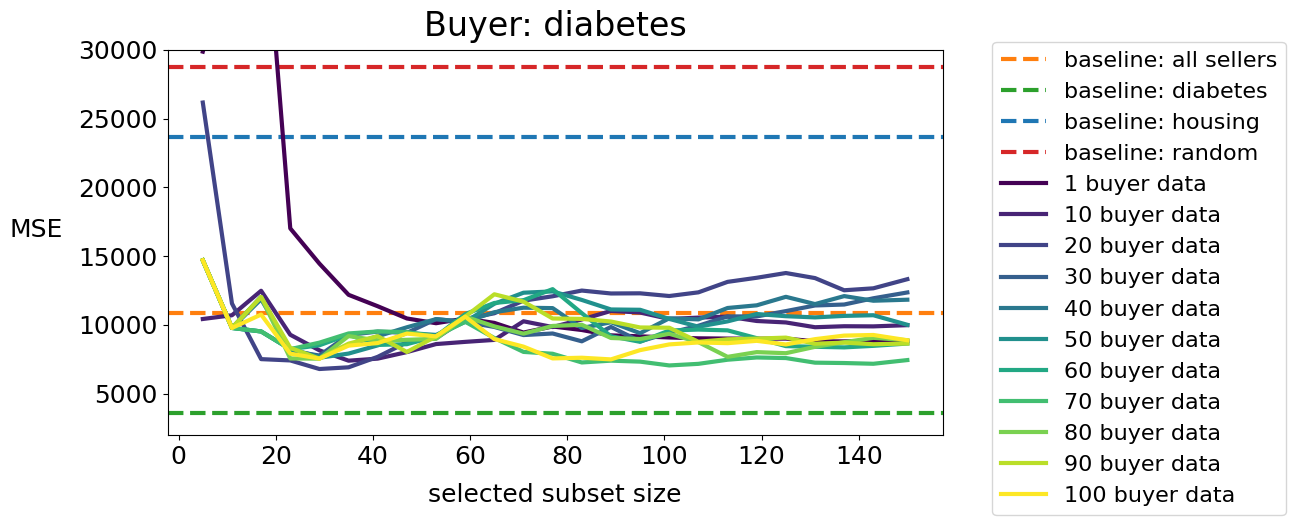

In [329]:
cmap = matplotlib.colormaps['viridis'].colors
colors = np.array(cmap)[np.linspace(0, 255, len(mse_results)).astype(int)]
plt.figure(figsize=(10, 5))
plt.axhline(diabetes_baseline_all, ls='--', label='baseline: all sellers', lw=3, c='C1',)
plt.axhline(diabetes_baseline_diabetes, ls='--', label='baseline: diabetes', lw=3, c='C2',)
plt.axhline(diabetes_baseline_housing, ls='--', label='baseline: housing', lw=3, c='C0',)
plt.axhline(diabetes_baseline_random, ls='--', label='baseline: random', lw=3, c='C3',)
for i, (k, v) in enumerate(diabetes_results.items()):
    plt.plot(subset_range, v, label=f'{k} buyer data', c=colors[i], lw=3)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.05, 1.05))
plt.title('Buyer: diabetes', fontsize=24, pad=10)
plt.xlabel('selected subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=30)
plt.ylim(2000, 30000)
plt.tick_params(labelsize=18)
plt.savefig('diabetes.png', bbox_inches='tight')

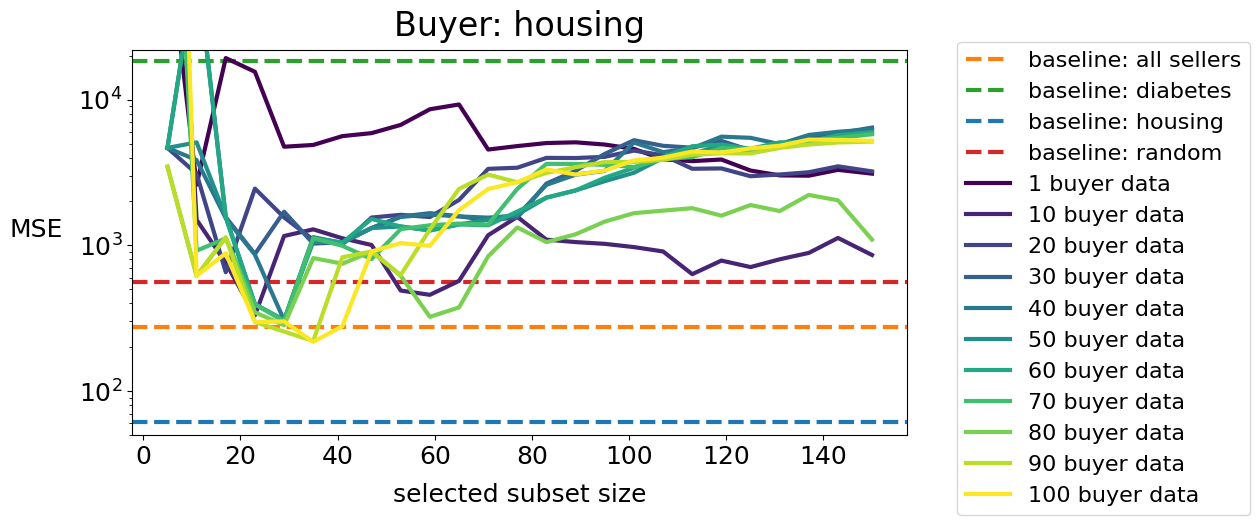

In [330]:
cmap = matplotlib.colormaps['viridis'].colors
colors = np.array(cmap)[np.linspace(0, 255, len(mse_results)).astype(int)]
plt.figure(figsize=(10, 5))
plt.axhline(housing_baseline_all, ls='--', label='baseline: all sellers', lw=3, c='C1',)
plt.axhline(housing_baseline_diabetes, ls='--', label='baseline: diabetes', lw=3, c='C2',)
plt.axhline(housing_baseline_housing, ls='--', label='baseline: housing', lw=3, c='C0',)
plt.axhline(housing_baseline_random, ls='--', label='baseline: random', lw=3, c='C3',)
for i, (k, v) in enumerate(housing_results.items()):
    plt.plot(subset_range, v, label=f'{k} buyer data', c=colors[i], lw=3)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.05, 1.05))
plt.title('Buyer: housing', fontsize=24, pad=10)
plt.xlabel('selected subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=30)
plt.yscale('log')
plt.ylim(50, 22000)
plt.tick_params(labelsize=18)
plt.savefig('housing.png', bbox_inches='tight')

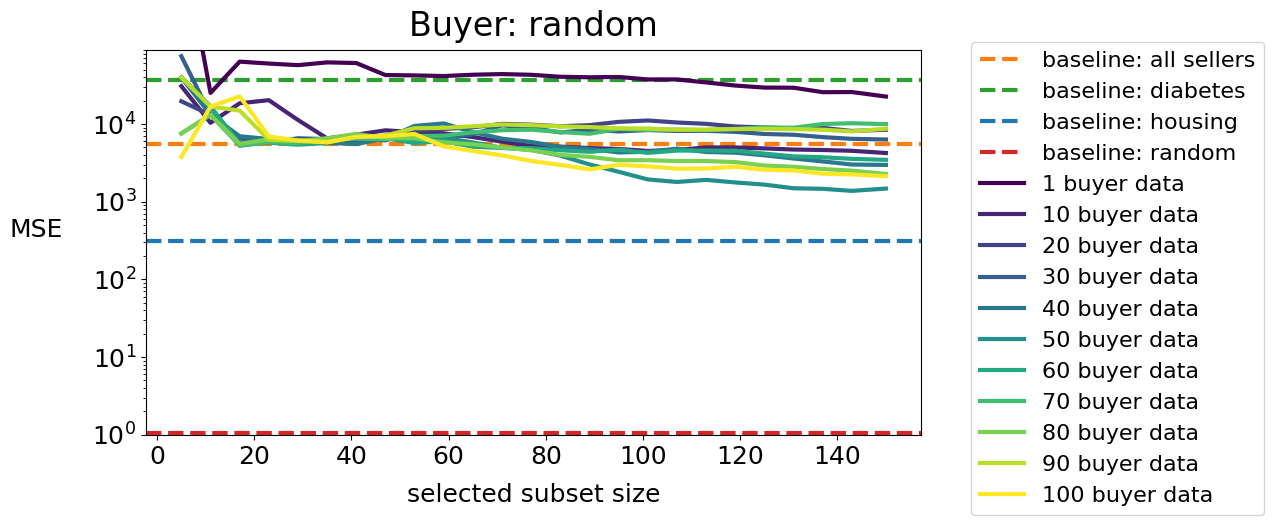

In [331]:
cmap = matplotlib.colormaps['viridis'].colors
colors = np.array(cmap)[np.linspace(0, 255, len(mse_results)).astype(int)]
plt.figure(figsize=(10, 5))
plt.axhline(random_baseline_all, ls='--', label='baseline: all sellers', lw=3, c='C1',)
plt.axhline(random_baseline_diabetes, ls='--', label='baseline: diabetes', lw=3, c='C2',)
plt.axhline(random_baseline_housing, ls='--', label='baseline: housing', lw=3, c='C0',)
plt.axhline(random_baseline_random, ls='--', label='baseline: random', lw=3, c='C3',)
for i, (k, v) in enumerate(random_results.items()):
    plt.plot(subset_range, v, label=f'{k} buyer data', c=colors[i], lw=3)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.05, 1.05))
plt.title('Buyer: random', fontsize=24, pad=10)
plt.xlabel('selected subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=40)
plt.yscale('log')
plt.ylim(1, 90000)
plt.tick_params(labelsize=18)
plt.savefig('random.png', bbox_inches='tight')

## Ablate $\lambda$ regularization

In [371]:
num_buyer = 100

lambda_1_range = [0.1, 1, 3, 5, 7]
lambda_2_range = [1, 3, 5, 7]

diabetes_lambda_weights = defaultdict(dict)
housing_lambda_weights = defaultdict(dict)
random_lambda_weights = defaultdict(dict)

for lam1, lam2 in tqdm(product(lambda_1_range, lambda_2_range), total=len(lambda_1_range) * len(lambda_2_range)):
    diabetes_lambda_weights[lam1][lam2] = optimize_seller_weights(seller_data_x, diabetes_buyer_x[:num_buyer], lam1=lam1, lam2=lam2)
    housing_lambda_weights[lam1][lam2] = optimize_seller_weights(seller_data_x, housing_buyer_x[:num_buyer], lam1=lam1, lam2=lam2)
    random_lambda_weights[lam1][lam2] = optimize_seller_weights(seller_data_x, random_buyer_x[:num_buyer], lam1=lam1, lam2=lam2)

  0%|          | 0/20 [00:00<?, ?it/s]

optimal 0:1.69	prob.value=1.40
optimal 0:2.33	prob.value=1.13
optimal 0:1.69	prob.value=1.40
optimal 0:2.09	prob.value=1.87
optimal 0:2.78	prob.value=1.53
optimal 0:2.28	prob.value=1.89
optimal 0:2.92	prob.value=2.23
optimal 0:2.68	prob.value=1.84
optimal 0:2.96	prob.value=2.25
optimal 0:3.36	prob.value=2.53
optimal 0:3.55	prob.value=2.09
optimal 0:3.93	prob.value=2.55
optimal 0:4.72	prob.value=3.26
optimal 0:8.95	prob.value=2.54
optimal 0:4.53	prob.value=3.19
optimal 0:4.40	prob.value=3.62
optimal 0:3.52	prob.value=2.88
optimal 0:3.56	prob.value=3.59
optimal 0:4.17	prob.value=3.89
optimal 0:4.29	prob.value=3.12
optimal 0:3.81	prob.value=3.88
optimal 0:4.91	prob.value=4.12
optimal 0:4.79	prob.value=3.32
optimal 0:4.52	prob.value=4.13
optimal 0:7.85	prob.value=5.31
optimal 0:12.54	prob.value=4.14
optimal 0:6.35	prob.value=5.14
optimal 0:6.96	prob.value=5.65
optimal 0:12.07	prob.value=4.41
optimal 0:6.88	prob.value=5.53
optimal 0:17.45	prob.value=5.89
optimal 0:14.38	prob.value=4.62
opti

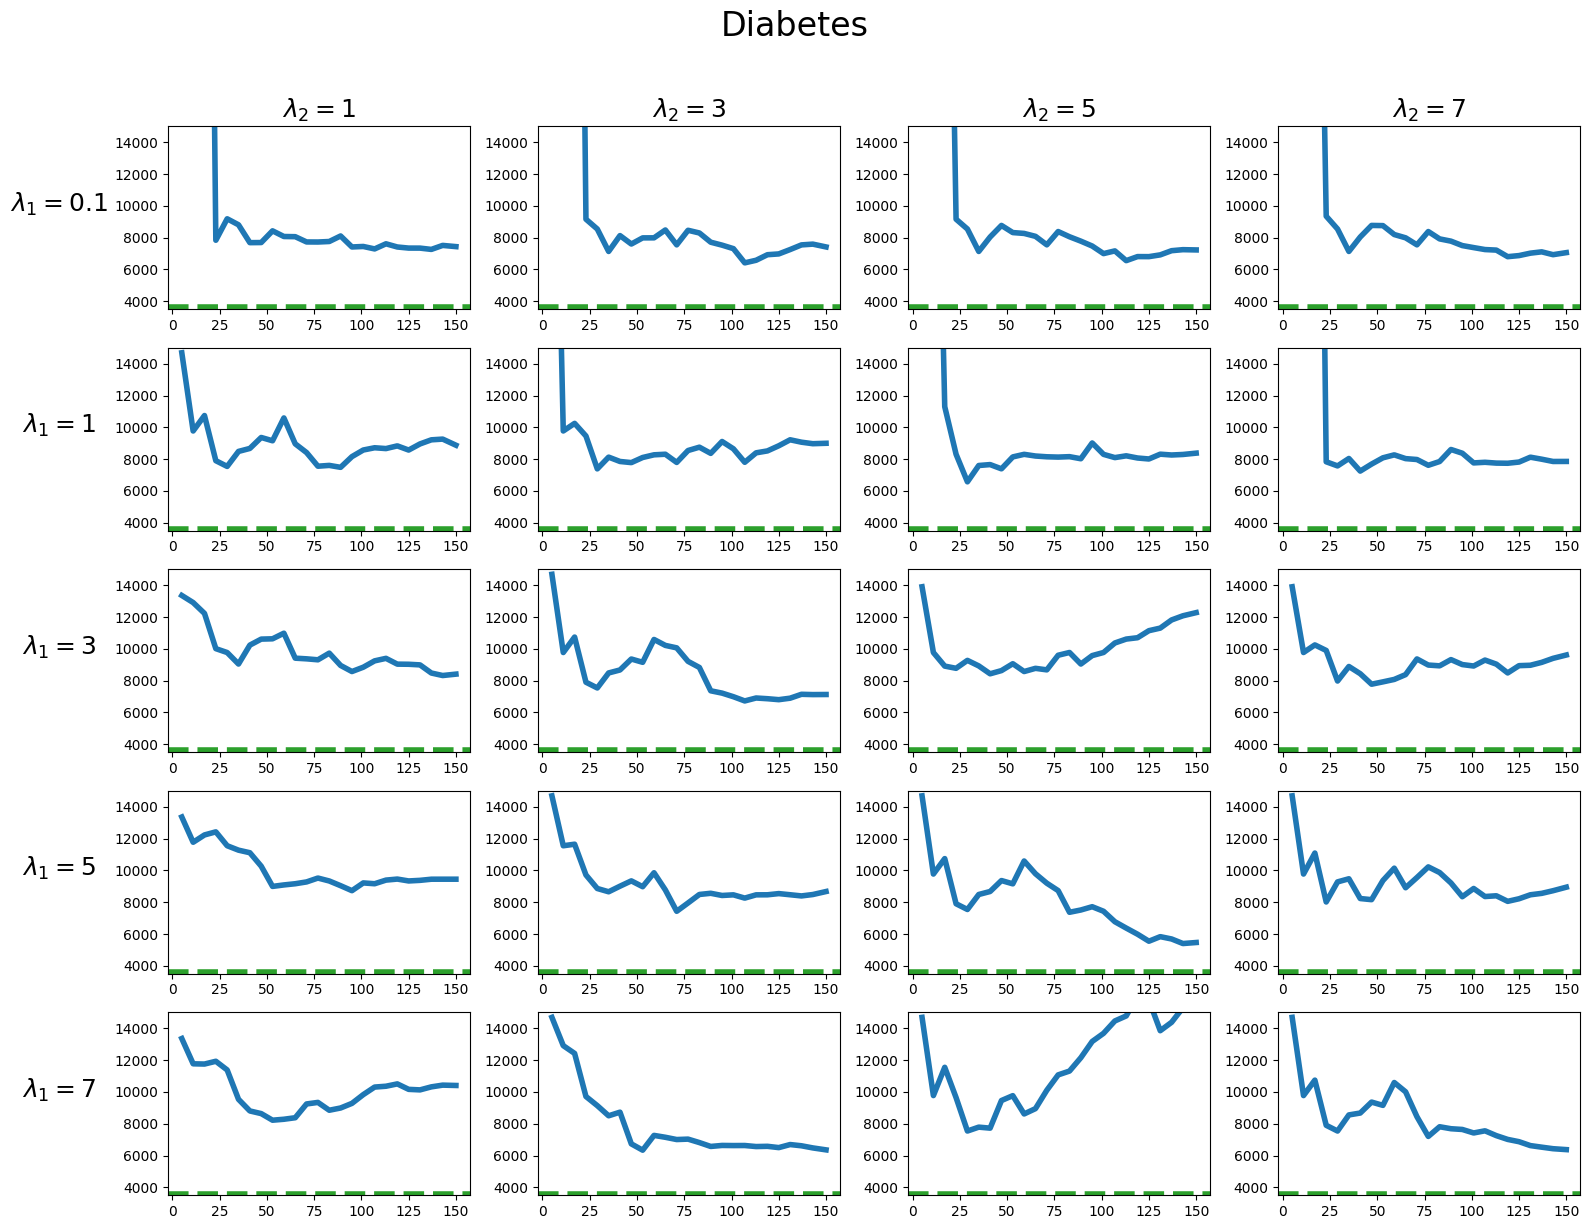

In [376]:
subset_range = [int(x) for x in np.linspace(5, 150, 25)]
# subset_range = [int(x) for x in np.linspace(5, 150, 5)]

baseline = fit_predict(diabetes_seller_x, diabetes_seller_y, diabetes_test_x, diabetes_test_y)

fig, ax = plt.subplots(nrows=len(lambda_1_range), ncols=len(lambda_2_range), figsize=(16, 12))

fig.suptitle('Diabetes', fontsize=24, y=1.02)
           
for i, lam1 in enumerate(lambda_1_range):
    for j, lam2 in enumerate(lambda_2_range):
        results = []
        weights = diabetes_lambda_weights[lam1][lam2]
        for num_selected in subset_range:
            indices = weights.argsort()[:-num_selected:-1]
            results.append(fit_predict(seller_data_x[indices], seller_data_y[indices], diabetes_test_x, diabetes_test_y))
        ax[i][j].plot(subset_range, results, lw=4)
        ax[i][j].axhline(baseline, ls='--', label='baseline', lw=4, c='C2')
        ax[i][j].set_ylim(3500, 15000)
        
        if i == 0:
            ax[i][j].set_title(fr'$\lambda_2=${lambda_2_range[j]}', fontsize=18)
            
        if j == 0:
            ax[i][j].set_ylabel(fr'$\lambda_1=${lambda_1_range[i]}', fontsize=18, rotation=0, labelpad=40)
        
fig.set_tight_layout(True)
plt.savefig('lambda-diabetes.png', bbox_inches='tight')

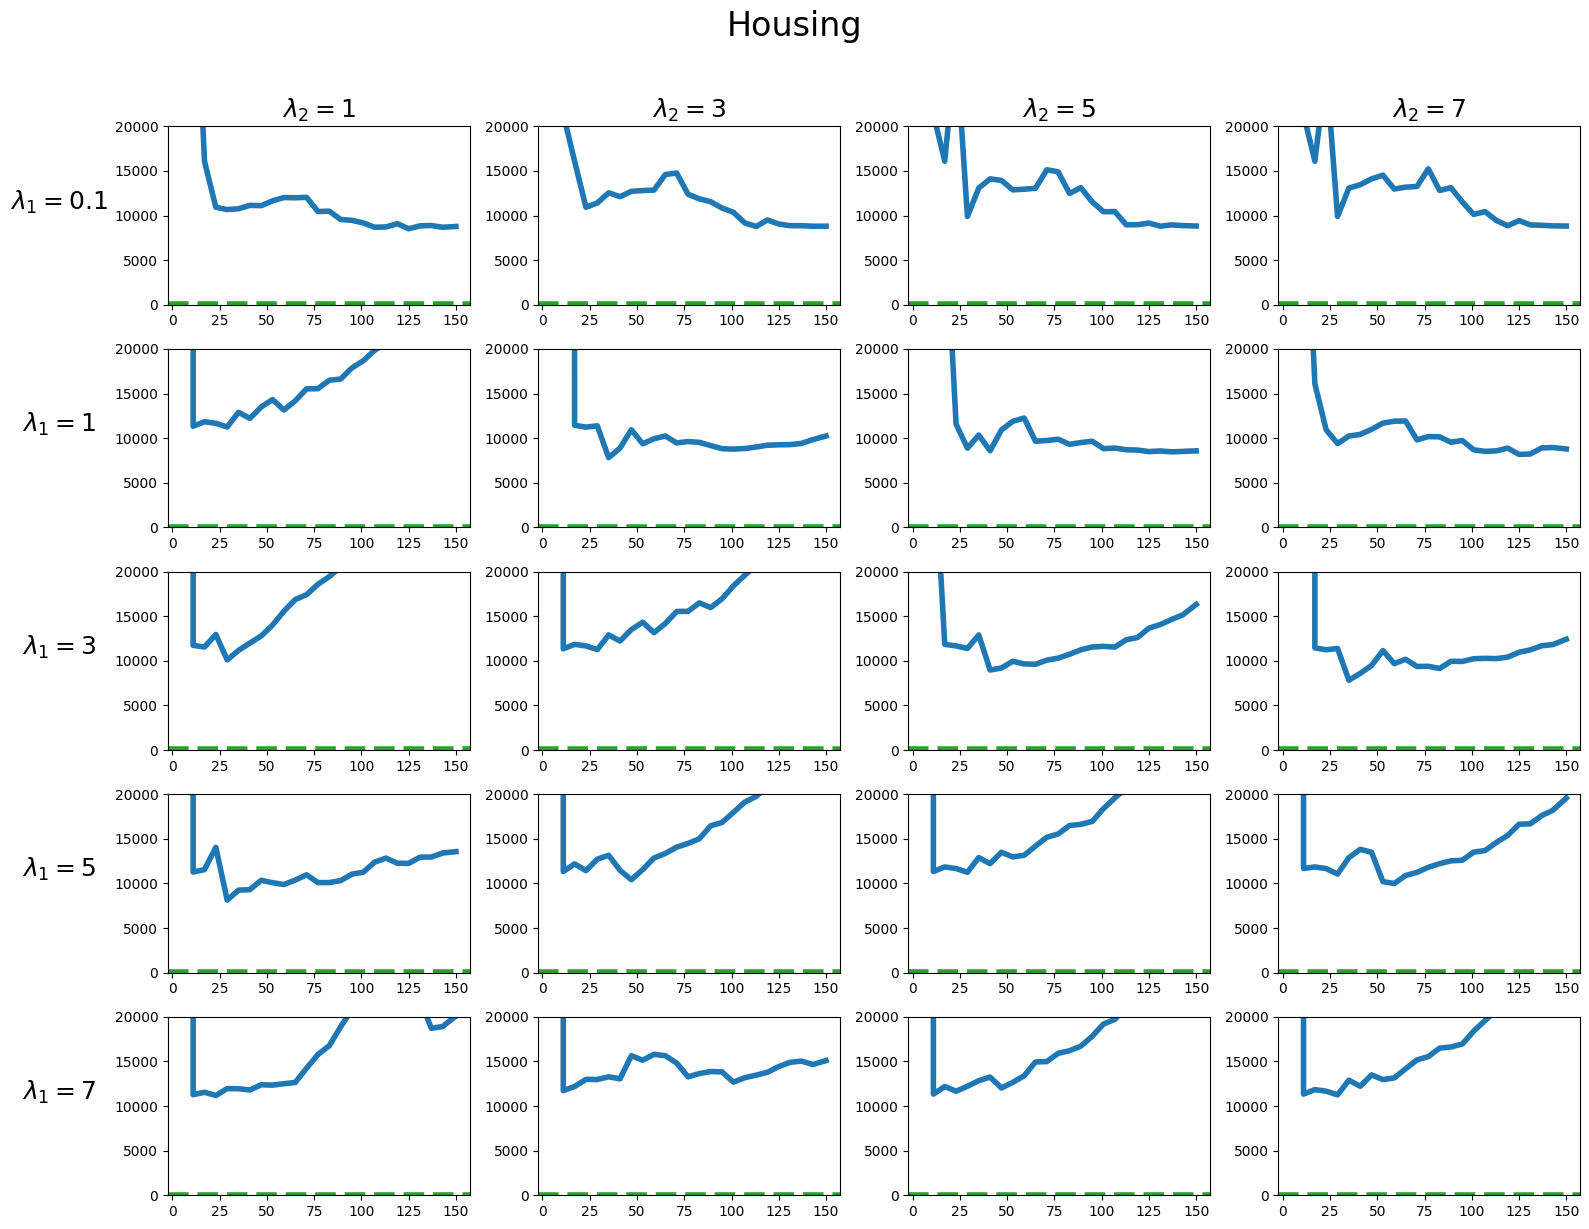

In [377]:
subset_range = [int(x) for x in np.linspace(5, 150, 25)]
# subset_range = [int(x) for x in np.linspace(5, 150, 5)]

baseline = fit_predict(housing_seller_x, housing_seller_y, housing_test_x, housing_test_y)

fig, ax = plt.subplots(nrows=len(lambda_1_range), ncols=len(lambda_2_range), figsize=(16, 12))

fig.suptitle('Housing', fontsize=24, y=1.02)
           
for i, lam1 in enumerate(lambda_1_range):
    for j, lam2 in enumerate(lambda_2_range):
        results = []
        weights = housing_lambda_weights[lam1][lam2]
        for num_selected in subset_range:
            indices = weights.argsort()[:-num_selected:-1]
            results.append(fit_predict(seller_data_x[indices], seller_data_y[indices], diabetes_test_x, diabetes_test_y))
        ax[i][j].plot(subset_range, results, lw=4)
        ax[i][j].axhline(baseline, ls='--', label='baseline', lw=4, c='C2')
        ax[i][j].set_ylim(0, 20000)
        
        if i == 0:
            ax[i][j].set_title(fr'$\lambda_2=${lambda_2_range[j]}', fontsize=18)
            
        if j == 0:
            ax[i][j].set_ylabel(fr'$\lambda_1=${lambda_1_range[i]}', fontsize=18, rotation=0, labelpad=40)
        
fig.set_tight_layout(True)
plt.savefig('lambda-housing.png', bbox_inches='tight')

In [ ]:
cmap = matplotlib.colormaps['viridis'].colors
colors = np.array(cmap)[np.linspace(0, 255, len(mse_results)).astype(int)]

plt.figure(figsize=(10, 6))
for i, (k, v) in enumerate(mse_results.items()):
    plt.plot(v, label=k, c=colors[i], lw=2)
plt.axhline(buyer_mse, ls='-', label='baseline: buyer', lw=3, c='k')
plt.axhline(seller_mse, ls=':', label='baseline: all sellers', lw=3, c='C0',)
plt.axhline(seller1_mse, ls='--', label='baseline: seller 1', lw=3, c='C1',)
plt.axhline(seller2_mse, ls='--', label='baseline: seller 2', lw=3, c='C2',)
plt.axhline(seller3_mse, ls='--', label='baseline: seller 3', lw=3, c='C3',)
# plt.axhline(seller4_mse, ls='--', label='baseline: seller 4', lw=3, c='C4',)
plt.axhline(noise_mse, ls='--', label='baseline: noise', lw=3, c='C5',)
plt.xlabel('selected subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=40)
# plt.ylim(30, 120)
# plt.ylim(30, 340)
plt.ylim(3000, 8000)
# plt.yscale('log')
plt.tick_params(labelsize=18)
plt.legend(title='number of buyer data', fontsize=16, title_fontsize=18, bbox_to_anchor=(1.05, 1.05))
# plt.savefig('housing.png', bbox_inches='tight')

In [ ]:

mse_results = defaultdict(list)

for n_ref in n_buyer_weights.keys():
    for n_train in np.arange(1, 300, 1):
        # selected_index = n_buyer_weights[n_ref].argsort()[-n_train:]
        selected_index = n_buyer_weights[n_ref].argsort()[:n_train]
        selected_weights = n_buyer_weights[n_ref][selected_index]
        selected_data = seller_data[selected_index]
        selected_targets = seller_targets[selected_index]

        LR = LinearRegression()
        LR.fit(selected_data, selected_targets)
        test_pred = LR.predict(test_data)
        mse = mean_squared_error(test_targets, test_pred).round(3)
        mse_results[n_ref].append(mse)

In [ ]:
                            
for n_buyer in tqdm([1, 5, 10, 20, 30, 40, 50, 60, 70]): 
    n_seller = seller_data.shape[0]

    w = cp.Variable((n_seller, 1))

    # def objective(seller, buyer, w, lam1=0.5, lam2=0.7):
    def objective(seller, buyer, w, lam1=5, lam2=5):
        n_seller = seller.shape[0]
        n_buyer = buyer.shape[0]
        cost = cp.matrix_frac(
                buyer.T,
                cp.sum([w[i] * seller[i][None].T @ seller[i][None] for i in range(n_seller)])
            ) / (n_buyer)
        reg1 = cp.norm1(w)
        reg2 = cp.pnorm(w)
        loss = cost + lam1 * reg1 + lam2 * reg2
        return loss

    # constraint = [w >= 0, sum(w) == 1]
    constraint = [w >= 0]
    prob = cp.Problem(
        cp.Minimize(
            objective(seller_data, buyer_data[:n_buyer], w)
        ),
        constraint,
    )

    start = perf_counter()
    prob.solve()
    end = perf_counter()
    runtime = end - start
    print(prob.status, f"{runtime//60:.0f}:{runtime%60:.2f}", n_buyer, prob.value.round(5))

    n_buyer_weights[n_buyer] = w.value.flatten()

In [673]:
seller1_data = seller_x[:100, [1, 9]]
seller2_data = seller_x[100:200, [0, 8]]
seller3_data = seller_x[200:300, [11, 12]]
# seller4_data = seller_x[225:300, 9:12]
noise_data = np.random.randn(100, 2)

seller1_targets = seller_y[:100]
seller2_targets = seller_y[100:200]
seller3_targets = seller_y[200:300]
# seller4_targets = seller_y[225:300]
noise_targets = np.random.choice(np.arange(seller_y.min(), seller_y.max()), 100)

seller_data = np.concatenate([seller1_data, seller2_data, seller3_data, noise_data])
seller_targets = np.concatenate([seller1_targets, seller2_targets, seller3_targets, noise_targets])

buyer1 = buyer_x[:, [1, 9]]
buyer2 = buyer_x[:, [0, 8]]
buyer3 = buyer_x[:, [11, 12]]
# buyer4 = buyer_x[:, 9:12]

buyer_data = buyer1
buyer_targets = buyer_y

test_data = test_x[:, [1, 9]]
test_targets = test_y

In [692]:
for i in range(x.shape[1]):
    print(i, pearsonr(x[:, i], y).statistic.round(3))

0 0.188
1 0.043
2 0.586
3 0.441
4 0.212
5 0.174
6 -0.395
7 0.43
8 0.566
9 0.382


In [766]:
seller1_data = seller_x[:200, [2, 3, 8]]
seller2_data = seller_x[:200, [3, 4, 9]]
seller3_data = seller_x[:200, [0, 1, 5]]
# seller4_data = seller_x[225:300, 9:12]
noise_data = np.random.randn(100, 3)

seller1_targets = seller_y[:200]
seller2_targets = seller_y[:200]
seller3_targets = seller_y[:200]
# seller4_targets = seller_y[225:300]
noise_targets = np.random.choice(np.arange(seller_y.min(), seller_y.max()), 100)

seller_data = np.concatenate([seller1_data, seller2_data, seller3_data])
seller_targets = np.concatenate([seller1_targets, seller2_targets, seller3_targets])

buyer1 = buyer_x[:, [2, 3, 8]]
buyer2 = buyer_x[:, [3, 4, 9]]
buyer3 = buyer_x[:, [0, 1, 5]]
# buyer4 = buyer_x[:, 9:12]

buyer_data = buyer1
buyer_targets = buyer_y

test_data = test_x[:, [2, 3, 8]]
test_targets = test_y

In [767]:

n_buyer_weights = {}

# for n_buyer in tqdm_notebook(np.arange(1, 75, 10)): 
for n_buyer in tqdm([1, 5, 10, 20, 30, 40, 50, 60, 70]): 
    n_seller = seller_data.shape[0]

    w = cp.Variable((n_seller, 1))

    # def objective(seller, buyer, w, lam1=0.5, lam2=0.7):
    def objective(seller, buyer, w, lam1=5, lam2=5):
        n_seller = seller.shape[0]
        n_buyer = buyer.shape[0]
        cost = cp.matrix_frac(
                buyer.T,
                cp.sum([w[i] * seller[i][None].T @ seller[i][None] for i in range(n_seller)])
            ) / (n_buyer)
        reg1 = cp.norm1(w)
        reg2 = cp.pnorm(w)
        loss = cost + lam1 * reg1 + lam2 * reg2
        return loss

    # constraint = [w >= 0, sum(w) == 1]
    constraint = [w >= 0]
    prob = cp.Problem(
        cp.Minimize(
            objective(seller_data, buyer_data[:n_buyer], w)
        ),
        constraint,
    )

    start = perf_counter()
    prob.solve()
    end = perf_counter()
    runtime = end - start
    print(prob.status, f"{runtime//60:.0f}:{runtime%60:.2f}", n_buyer, prob.value.round(5))

    n_buyer_weights[n_buyer] = w.value.flatten()

  0%|          | 0/9 [00:00<?, ?it/s]

optimal 0:2.92 1 3.16306
optimal 0:4.55 5 4.22373
optimal 0:4.63 10 4.88335
optimal 0:6.59 20 4.77102
optimal 0:10.23 30 5.2105
optimal 0:16.26 40 4.96442
optimal 0:12.33 50 4.64401
optimal 0:22.33 60 4.73825
optimal 0:32.47 70 4.66659


In [768]:

LR = LinearRegression()
LR.fit(buyer_data, buyer_targets)

test_pred = LR.predict(test_data)
buyer_mse = mean_squared_error(test_targets, test_pred).round(1)
print('true buyer:', buyer_mse)

LR = LinearRegression()
LR.fit(seller_data, seller_targets)

test_pred = LR.predict(test_data)
seller_mse = mean_squared_error(test_targets, test_pred).round(1)
print('all sellers:', seller_mse)


LR = LinearRegression()
LR.fit(seller1_data, seller1_targets)

test_pred = LR.predict(test_data)
seller1_mse = mean_squared_error(test_targets, test_pred).round(1)
print('seller 1:', seller1_mse)

LR = LinearRegression()
LR.fit(seller2_data, seller2_targets)

test_pred = LR.predict(test_data)
seller2_mse = mean_squared_error(test_targets, test_pred).round(1)
print('seller 2:', seller2_mse)

LR = LinearRegression()
LR.fit(seller3_data, seller3_targets)

test_pred = LR.predict(test_data)
seller3_mse = mean_squared_error(test_targets, test_pred).round(1)
print('seller 3:', seller3_mse)

# LR = LinearRegression()
# LR.fit(seller4_data, seller4_targets)

# test_pred = LR.predict(test_data)
# seller4_mse = mean_squared_error(test_targets, test_pred).round(1)
# print('seller 4:', seller4_mse)

LR = LinearRegression()
LR.fit(noise_data, noise_targets)

test_pred = LR.predict(test_data)
noise_mse = mean_squared_error(test_targets, test_pred).round(1)
print('noise seller:', noise_mse)

true buyer: 3534.9
all sellers: 3357.9
seller 1: 3329.7
seller 2: 3471.7
seller 3: 3819.7
noise seller: 7878.1


In [772]:
from collections import defaultdict
mse_results = defaultdict(list)

for n_ref in n_buyer_weights.keys():
    for n_train in np.arange(1, 300, 1):
        # selected_index = n_buyer_weights[n_ref].argsort()[-n_train:]
        selected_index = n_buyer_weights[n_ref].argsort()[:n_train]
        selected_weights = n_buyer_weights[n_ref][selected_index]
        selected_data = seller_data[selected_index]
        selected_targets = seller_targets[selected_index]

        LR = LinearRegression()
        LR.fit(selected_data, selected_targets)
        test_pred = LR.predict(test_data)
        mse = mean_squared_error(test_targets, test_pred).round(3)
        mse_results[n_ref].append(mse)

In [773]:
b = 30
k = 100
(n_buyer_weights[b].argsort()[-k:] < 100)
# (150 < n_buyer_weights[b].argsort()[-k:]) & (n_buyer_weights[b].argsort()[-k:] < 225)

array([False,  True, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False,  True,  True,  True, False, False,  True, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False,  True,  True, False,  True, False, False, False,  True,
       False])

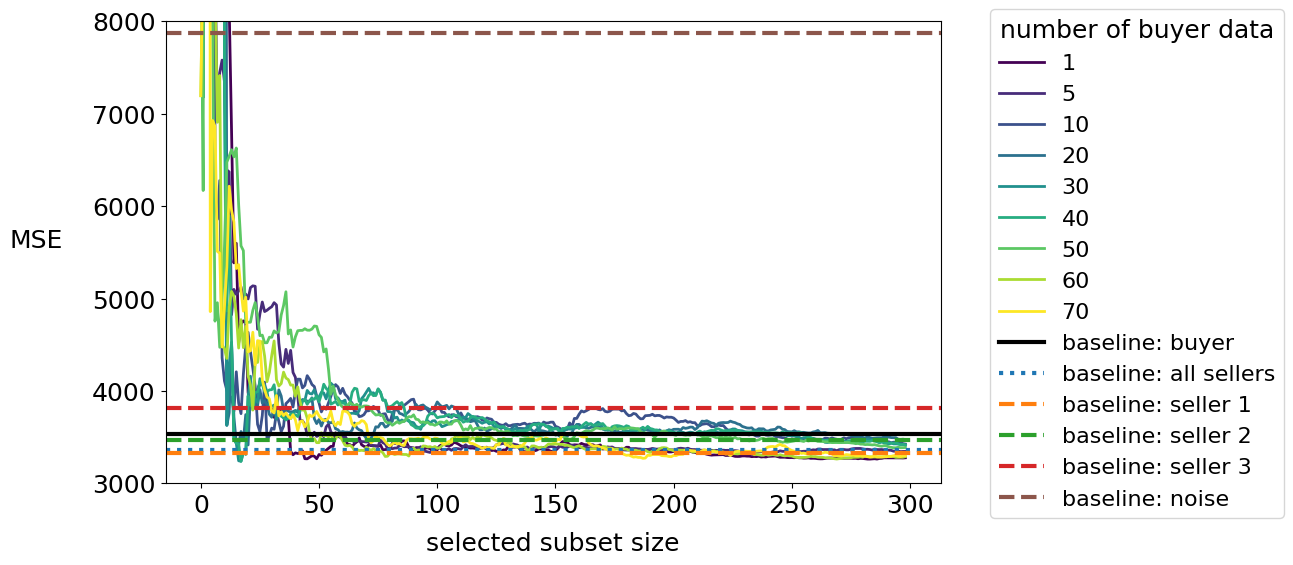

In [774]:
import matplotlib
cmap = matplotlib.colormaps['viridis'].colors
colors = np.array(cmap)[np.linspace(0, 255, len(mse_results)).astype(int)]

plt.figure(figsize=(10, 6))
for i, (k, v) in enumerate(mse_results.items()):
    plt.plot(v, label=k, c=colors[i], lw=2)
plt.axhline(buyer_mse, ls='-', label='baseline: buyer', lw=3, c='k')
plt.axhline(seller_mse, ls=':', label='baseline: all sellers', lw=3, c='C0',)
plt.axhline(seller1_mse, ls='--', label='baseline: seller 1', lw=3, c='C1',)
plt.axhline(seller2_mse, ls='--', label='baseline: seller 2', lw=3, c='C2',)
plt.axhline(seller3_mse, ls='--', label='baseline: seller 3', lw=3, c='C3',)
# plt.axhline(seller4_mse, ls='--', label='baseline: seller 4', lw=3, c='C4',)
plt.axhline(noise_mse, ls='--', label='baseline: noise', lw=3, c='C5',)
plt.xlabel('selected subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=40)
# plt.ylim(30, 120)
# plt.ylim(30, 340)
plt.ylim(3000, 8000)
# plt.yscale('log')
plt.tick_params(labelsize=18)
plt.legend(title='number of buyer data', fontsize=16, title_fontsize=18, bbox_to_anchor=(1.05, 1.05))
# plt.savefig('housing.png', bbox_inches='tight')

In [135]:
n_buyer_weights[1][272]

0.058498138394185155

In [ ]:
mse_results_15 = {}
mse_results_25 = {}
mse_results_50 = {}
mse_results_75 = {}
mse_results_100 = {}

from sklearn.linear_model import LinearRegression

for num_train_points in (15, 25, 50, 75, 100):
    subset_index = w.value.flatten().argsort()[::-1][:num_train_points]
    subset_weights = w.value[subset_index]
    subset_data = seller_data[subset_index]
    subset_targets = seller_targets[subset_index]
    # print(subset_weights)


    LR = LinearRegression()

    LR.fit(subset_data, subset_targets)

    test_pred = LR.predict(test_data)

    from sklearn.metrics import mean_squared_error

    mse = mean_squared_error(test_targets, test_pred)
    print(n_buyer, mse.round(), '\t', ((50 > subset_index) & (subset_index > 0)).sum(), '/', num_train_points)
    # print(n_buyer, mse.round(), '\t', ((100 > subset_index) & (subset_index > 50)).sum(), '/', num_train_points)
    match num_train_points:
        case 15:
            mse_results_15[n_buyer] = mse
        case 25:
            mse_results_25[n_buyer] = mse
        case 50:
            mse_results_50[n_buyer] = mse
        case 75:
            mse_results_75[n_buyer] = mse
        case 100:
            mse_results_100[n_buyer] = mse

In [689]:

from sklearn.datasets import load_diabetes

data = load_diabetes()
x = data["data"]
y = data["target"]

In [692]:
from scipy.stats import pearsonr
for i in range(x.shape[1]):
    print(i, pearsonr(x[:, i], y).statistic.round(3))

0 0.188
1 0.043
2 0.586
3 0.441
4 0.212
5 0.174
6 -0.395
7 0.43
8 0.566
9 0.382


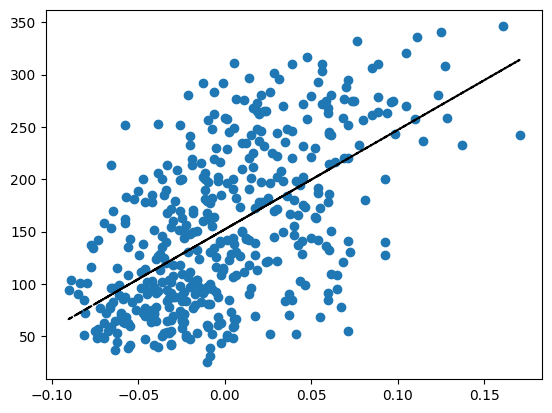

In [26]:
import matplotlib.pyplot as plt
_x = x[:, 2]
plt.scatter(_x, y) 
m, b = np.polyfit(_x, y, 1)
plt.plot(_x, m*_x + b, '--k')

In [316]:
x[0]

array([ 0.03807591,  0.05068012,  0.06169621,  0.02187239, -0.0442235 ,
       -0.03482076, -0.04340085, -0.00259226,  0.01990749, -0.01764613])

In [317]:
seller_data[200]

array([0.06169621, 0.02187239])

In [329]:
import numpy as np

seller_data = np.concatenate([x[:50, [0, 1]], x[50:100, [2, 3]], x[100:150, [4, 5]], x[150:200, [6, 7]]])
# seller_targets = np.tile(y[:200], 4)
seller_targets = y[:200]

# seller_data = np.concatenate([x[:200, [0, 1]], x[:200, [2, 3]], x[:200, [4, 5]]])
# seller_targets = np.tile(y[:200], 3)

# buyer_data = x[200:300, [0, 1]]
# buyer_targets = y[200:300]

# test_data = x[300:400, [0, 1]]
# test_targets = y[300:400]

buyer_data = x[200:300, [2, 3]]
buyer_targets = y[200:300]

test_data = x[300:400, [2, 3]]
test_targets = y[300:400]

In [ ]:
from time import perf_counter
import cvxpy as cp

mse_results_15 = {}
mse_results_25 = {}
mse_results_50 = {}
mse_results_75 = {}
mse_results_100 = {}

for n_buyer in np.arange(1, 50, 5): 
    n_seller = seller_data.shape[0]

    w = cp.Variable((n_seller, 1))

    def objective(seller, buyer, w, lam1=2.5, lam2=3.0):
        n_seller = seller.shape[0]
        n_buyer = buyer.shape[0]
        cost = cp.matrix_frac(
                buyer.T,
                cp.sum([w[i] * seller[i][None].T @ seller[i][None] for i in range(n_seller)])
            ) / (n_buyer)
        reg1 = cp.norm1(w)
        reg2 = cp.pnorm(w)
        loss = cost + lam1 * reg1 + lam2 * reg2
        return loss

    # constraint = [w >= 0, sum(w) == 1]
    constraint = [w >= 0]
    prob = cp.Problem(
        cp.Minimize(
            objective(seller_data, buyer_data[:n_buyer], w)
        ),
        constraint,
    )

    start = perf_counter()
    prob.solve()
    end = perf_counter()
    runtime = end - start
    print(prob.status, f"{runtime//60:.0f}:{runtime%60:.2f}", prob.value.round(5))

    from sklearn.linear_model import LinearRegression

    for num_train_points in (15, 25, 50, 75, 100):
        subset_index = w.value.flatten().argsort()[::-1][:num_train_points]
        subset_weights = w.value[subset_index]
        subset_data = seller_data[subset_index]
        subset_targets = seller_targets[subset_index]
        # print(subset_weights)


        LR = LinearRegression()

        LR.fit(subset_data, subset_targets)

        test_pred = LR.predict(test_data)

        from sklearn.metrics import mean_squared_error

        mse = mean_squared_error(test_targets, test_pred)
        print(n_buyer, mse.round(), '\t', ((50 > subset_index) & (subset_index > 0)).sum(), '/', num_train_points)
        # print(n_buyer, mse.round(), '\t', ((100 > subset_index) & (subset_index > 50)).sum(), '/', num_train_points)
        match num_train_points:
            case 15:
                mse_results_15[n_buyer] = mse
            case 25:
                mse_results_25[n_buyer] = mse
            case 50:
                mse_results_50[n_buyer] = mse
            case 75:
                mse_results_75[n_buyer] = mse
            case 100:
                mse_results_100[n_buyer] = mse

optimal 0:0.43 2.13424
1 4876.0 	 4 / 15
1 5276.0 	 8 / 25
1 5492.0 	 18 / 50
1 5287.0 	 21 / 75
1 4945.0 	 22 / 100
optimal 0:0.46 1.65134
6 5949.0 	 2 / 15
6 5400.0 	 8 / 25
6 6025.0 	 17 / 50
6 6171.0 	 22 / 75
6 6108.0 	 26 / 100
optimal 0:1.43 1.71221
11 6185.0 	 1 / 15
11 6092.0 	 8 / 25
11 6624.0 	 19 / 50
11 6650.0 	 21 / 75
11 6285.0 	 23 / 100
optimal 0:1.45 1.86068
16 7027.0 	 1 / 15
16 6053.0 	 7 / 25
16 6638.0 	 18 / 50
16 6891.0 	 21 / 75
16 6707.0 	 21 / 100
optimal 0:4.73 1.89265
21 5516.0 	 1 / 15
21 4997.0 	 1 / 25
21 5345.0 	 17 / 50
21 5139.0 	 33 / 75
21 5179.0 	 37 / 100
optimal 0:8.47 1.92593
26 5505.0 	 1 / 15
26 5667.0 	 3 / 25
26 4857.0 	 22 / 50
26 5125.0 	 31 / 75
26 5114.0 	 37 / 100
optimal 0:12.98 2.0375
31 4786.0 	 7 / 15
31 4733.0 	 12 / 25
31 5162.0 	 17 / 50
31 5473.0 	 19 / 75
31 5027.0 	 22 / 100


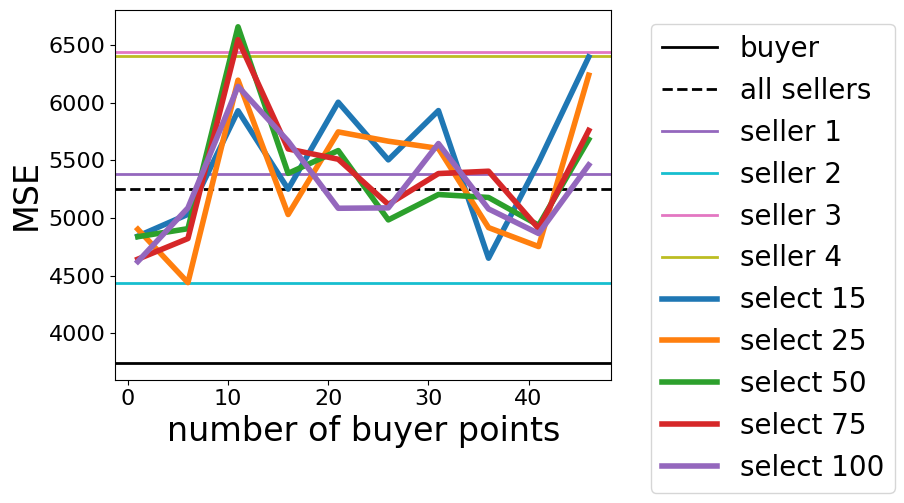

In [331]:
LR.fit(buyer_data, buyer_targets)
buyer_mse = mean_squared_error(test_targets, LR.predict(test_data))
plt.axhline(buyer_mse, label='buyer', c='k', ls='-', lw=2)

LR.fit(seller_data, seller_targets)
seller_mse = mean_squared_error(test_targets, LR.predict(test_data))
plt.tick_params(labelsize=16)
plt.axhline(seller_mse, label='all sellers', c='k', ls='--', lw=2)

LR.fit(seller_data[:50], seller_targets[:50])
seller_mse = mean_squared_error(test_targets, LR.predict(test_data))
plt.axhline(seller_mse, label='seller 1',  ls='-', lw=2, c='C4')

LR.fit(seller_data[50:100], seller_targets[50:100])
seller_mse = mean_squared_error(test_targets, LR.predict(test_data))
plt.axhline(seller_mse, label='seller 2',  ls='-', lw=2, c='C9')

LR.fit(seller_data[100:150], seller_targets[100:150])
seller_mse = mean_squared_error(test_targets, LR.predict(test_data))
plt.axhline(seller_mse, label='seller 3',  ls='-', lw=2, c='C6')

LR.fit(seller_data[150:200], seller_targets[150:200])
seller_mse = mean_squared_error(test_targets, LR.predict(test_data))
plt.axhline(seller_mse, label='seller 4',  ls='-', lw=2, c='C8')

# plt.plot(*zip(*mse_results_2.items()), label='select 2', lw=4)
# plt.plot(*zip(*mse_results_5.items()), label='select 5', lw=4)
# plt.plot(*zip(*mse_results_10.items()), label='select 10', lw=4)
plt.plot(*zip(*mse_results_15.items()), label='select 15', lw=4)
plt.plot(*zip(*mse_results_25.items()), label='select 25', lw=4)
plt.plot(*zip(*mse_results_50.items()), label='select 50', lw=4)
plt.plot(*zip(*mse_results_75.items()), label='select 75', lw=4)
plt.plot(*zip(*mse_results_100.items()), label='select 100', lw=4)
plt.xlabel('number of buyer points', fontsize=24)
plt.ylabel('MSE', fontsize=24)
plt.legend(fontsize=20, loc='upper right', bbox_to_anchor=(1.6, 1))

In [57]:
import numpy as np

features = [2, 8]
x_sub = x[:, features]

num_noise_points = 20
# noise_data = np.random.randn(num_noise_points, 10)
noise_data = np.random.gamma(1, size=(num_noise_points, len(features)))
noise_targets = np.random.choice(np.arange(y.min(), y.max()), num_noise_points)

seller_data = x_sub[:200]
seller_targets = y[:200]

seller_data = np.vstack([seller_data, noise_data])
seller_targets = np.concatenate([seller_targets, noise_targets])

buyer_data = x_sub[200:300]
buyer_targets = y[200:300]

test_data = x_sub[300:400]
test_targets = y[300:400]

In [59]:
from time import perf_counter
import cvxpy as cp

noise_mse_results_10 = {}
noise_mse_results_20 = {}
noise_mse_results_30 = {}
noise_mse_results_40 = {}
noise_mse_results_50 = {}
noise_select_results_10 = {}
noise_select_results_20 = {}
noise_select_results_30 = {}
noise_select_results_40 = {}
noise_select_results_50 = {}
# for n_buyer in (1, 2, 3, 10, 25, 50):
for n_buyer in range(1, 10):
    n_seller = seller_data.shape[0]

    w = cp.Variable((n_seller, 1))

    def objective(seller, buyer, w, lam1=0.1, lam2=0.1):
        n_seller = seller.shape[0]
        n_buyer = buyer.shape[0]
        cost = cp.sum([
            cp.matrix_frac(
                buyer[j].T,
                cp.sum([w[i] * seller[i][None].T @ seller[i][None] for i in range(n_seller)])
            ) for j in range(n_buyer)
        ])
        reg1 = cp.norm1(w)
        reg2 = cp.pnorm(w)
        loss = cost + lam1 * reg1 + lam2 * reg2
        return loss

    constraint = [w >= 0]
    prob = cp.Problem(
        cp.Minimize(
            objective(seller_data, buyer_data[:n_buyer], w)
        ),
        constraint,
    )

    start = perf_counter()
    prob.solve()
    end = perf_counter()
    runtime = end - start
    print(f"{runtime//60:.0f}:{runtime%60:.2f}")
    print(prob.status)
    # print(w.value.round(3))
    # print(np.argsort(w.value.flatten())[::-1])

    from sklearn.linear_model import LinearRegression

    for num_train_points in (10, 20, 30, 40, 50):
        # subset_index = np.argpartition(w.value.flatten(), -num_train_points)[-num_train_points:]
        subset_index = w.value.flatten().argsort()[::-1][:num_train_points]
        subset_weights = w.value[subset_index]
        subset_data = seller_data[subset_index]
        subset_targets = seller_targets[subset_index]
        # print(subset_weights)

        LR = LinearRegression()

        LR.fit(subset_data, subset_targets)

        test_pred = LR.predict(test_data)

        from sklearn.metrics import mean_squared_error

        num_noise_selected = (subset_index > (n_seller - num_noise_points)).sum()

        mse = mean_squared_error(test_targets, test_pred)
        print(n_buyer, mse, num_noise_selected, num_train_points)
        
        match num_train_points:
            case 10:
                noise_mse_results_10[n_buyer] = mse
                noise_select_results_10[n_buyer] = num_noise_selected
            case 20:
                noise_mse_results_20[n_buyer] = mse
                noise_select_results_20[n_buyer] = num_noise_selected
            case 30:
                noise_mse_results_30[n_buyer] = mse
                noise_select_results_30[n_buyer] = num_noise_selected
            case 40:
                noise_mse_results_40[n_buyer] = mse
                noise_select_results_40[n_buyer] = num_noise_selected
            case 50:
                noise_mse_results_50[n_buyer] = mse
                noise_select_results_50[n_buyer] = num_noise_selected

0:0.41
optimal
1 6588.28103224427 10 10
1 6032.29732498949 14 20
1 6100.270734965725 14 30
1 5763.005129817475 14 40
1 5885.866487954607 14 50
0:0.65
optimal
2 7430.683241160548 9 10
2 7694.906307931468 13 20
2 5949.289417582997 13 30
2 5676.21157933649 13 40
2 5712.3565033396535 13 50
0:0.96
optimal
3 5611.251146220387 10 10
3 5617.132118982454 15 20
3 5608.332219313052 15 30
3 6225.504793254084 15 40
3 6007.499329664948 15 50
0:1.62
optimal
4 12624.877716418267 10 10
4 5748.573207639941 18 20
4 5677.388271322246 19 30
4 5788.0707886448945 19 40
4 5942.714163265228 19 50
0:1.83
optimal
5 6048.480478181193 3 10
5 5644.9682346769705 3 20
5 5639.0629111575 3 30
5 5631.007433265101 3 40
5 5620.488281348195 3 50
0:2.25
optimal
6 6225.2774441317015 9 10
6 5746.452640445946 10 20
6 5719.209636279115 10 30
6 5733.371803822723 10 40
6 5706.536320726617 10 50


/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


0:2.63
optimal
7 5950.568784951291 4 10
7 5673.295349824911 4 20
7 5718.599951822555 4 30
7 5715.743577711932 4 40
7 5711.330820334099 4 50


/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


0:2.98
optimal
8 5761.551517902966 9 10
8 6149.552281760127 19 20
8 5740.949607161927 19 30
8 5663.61149120783 19 40
8 5736.046264636257 19 50


/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


0:3.44
optimal
9 5761.551517902968 9 10
9 5748.573207639941 18 20
9 5658.284390362927 19 30
9 5788.0707886448945 19 40
9 5832.679441031826 19 50


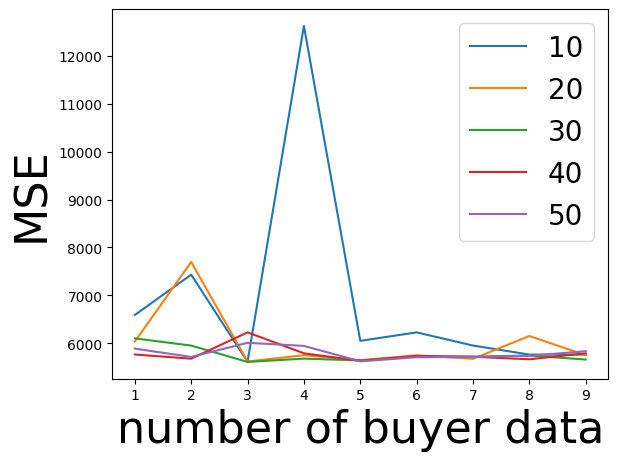

In [60]:
plt.plot(*zip(*noise_mse_results_10.items()), label='10')
plt.plot(*zip(*noise_mse_results_20.items()), label='20')
plt.plot(*zip(*noise_mse_results_30.items()), label='30')
plt.plot(*zip(*noise_mse_results_40.items()), label='40')
plt.plot(*zip(*noise_mse_results_50.items()), label='50')
plt.xlabel('number of buyer data', fontsize=32)
plt.ylabel('MSE', fontsize=32)
plt.legend(fontsize=20, loc='upper right')

In [ ]:
import matplotlib.pyplot as plt 
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
ax[0].plot(*zip(*mse_results.items()))
ax[0].set_xlabel('Number of buyer data points', fontsize=fontsize)
ax[0].set_ylabel('MSE', fontsize=fontsize)
ax[1].plot(*zip(*noise_results.items()))
ax[1].set_xlabel('Number of buyer data points', fontsize=fontsize)
ax[1].set_ylabel('Number of noise points selected', fontsize=fontsize)

In [229]:
noise.shape

(4, 10)

In [173]:
import cvxpy as cp
import numpy as np

# Problem data.
# m is matrix dimension, n is number of terms
m, n = 5, 10
X = np.random.randn(m, n)
b = np.abs(np.random.randn(n))  # constraint upper bounds
a = np.abs(np.random.randn(n))  # objective coefficients

# Construct the problem.
T = cp.Variable(n)
A = cp.Variable((m, m))
objective = cp.Minimize(a @ T)
constraints = (
    [A == X @ cp.diag(T) @ X.T]
    + [T >= 0]
    + [cp.matrix_frac(x, A) <= bi for x, bi in zip(X.T, b)]
)
problem = cp.Problem(objective, constraints)

# Report solution.
result = problem.solve()
print(result)

5.2534135822159245


In [189]:
x[2]

array([ 0.08529891,  0.05068012,  0.04445121, -0.00567042, -0.04559945,
       -0.03419447, -0.03235593, -0.00259226,  0.00286131, -0.02593034])

In [72]:
# np.linalg.inv(np.sum(x[i][None].T @ x[i][None] for i in range(1, 10))).shape

In [73]:
# np.linalg.inv(x[0][None].T @ x[0][None])

In [28]:
for i in range(1, 10):
    
print(x[i] np.linalg.inv

array([ 0.03807591,  0.05068012,  0.06169621,  0.02187239, -0.0442235 ,
       -0.03482076, -0.04340085, -0.00259226,  0.01990749, -0.01764613])

(array([38., 80., 68., 62., 50., 41., 38., 42., 17.,  6.]),
 array([ 25. ,  57.1,  89.2, 121.3, 153.4, 185.5, 217.6, 249.7, 281.8,
        313.9, 346. ]),
 <BarContainer object of 10 artists>)

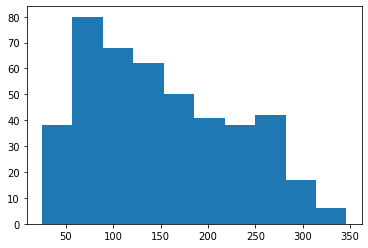

In [26]:
import matplotlib.pyplot as plt

plt.hist(y)

In [3]:
import cvxpy as cp

x = cp.Variable()
y = cp.Variable()

constraints = [x + y == 1, x - y >= 1]

obj = cp.Minimize((x - y) ** 2)

prob = cp.Problem(obj, constraints)
prob.solve()

1.0

In [7]:
x.value, y.value

(array(1.), array(1.57008621e-22))

In [9]:
cp.Variable(5)

Variable((5,))